In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import folium
import requests
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
from splot.libpysal import plot_spatial_weights
from folium.plugins import MarkerCluster
from pysal.lib import weights

In [21]:
import warnings
warnings.filterwarnings("ignore")

### Load the final data

In [22]:
# Load all the gdfs
cleaned_gdf = gpd.read_file("data/cleaned_data.geojson")

In [23]:
cleaned_gdf.head()

,interest,interest_name,website,phone,opening_hours,wheelchair,cuisine,diet:vegan,diet:vegetarian,geometry
0,sports_centre,Milestedets Ungdomshus,None,None,None,None,None,None,None,POINT (12.45204 55.67045)
1,sports_centre,Frankrigsgades Svømmehal,None,None,None,None,None,None,None,POINT (12.60993 55.66309)
2,sports_centre,Damsøbadet,None,None,None,None,None,None,None,POINT (12.49868 55.68014)
3,sports_centre,Amagerhallen,None,None,None,None,None,None,None,POINT (12.61549 55.62391)
4,sports_centre,Travbanehallen,None,None,None,None,None,None,None,POINT (12.61394 55.62416)


### Filtering

In [126]:
# Create checkboxes for user interests
coffee_checkbox = widgets.Checkbox(value=False, description='Coffee shops')
bakery_checkbox = widgets.Checkbox(value=False, description='Bakery')
vintage_checkbox = widgets.Checkbox(value=False, description='Vintage or thrift shops')
library_checkbox = widgets.Checkbox(value=False, description='Library')
attractions_checkbox = widgets.Checkbox(value=False, description='Tourist attractions')
nightlife_checkbox = widgets.Checkbox(value=False, description='Nightlife')

# Create checkboxes for selecting profiles
sports_checkbox = widgets.Checkbox(value=False, description='Sports fan')
theatre_checkbox = widgets.Checkbox(value=False, description='Theatre lover')

# Create checkbox for selecting restaurant preference
restaurant_checkbox = widgets.Checkbox(value=False, description='Restaurant')

# Create toggle buttons for selecting type of cuisine
cuisine_toggle_buttons = widgets.ToggleButtons(
    options=['Italian', 'Mexican', 'Japanese', 'Indian', 'Chinese', 'American', 'Spanish', 'All'],
    description='Cuisine:',
    disabled=True
)

# Create toggle buttons for selecting diet preferences
diet_toggle_buttons = widgets.ToggleButtons(
    options=['None', 'Vegetarian', 'Vegan'],
    description='Diet:',
    disabled=True
)

# Create output widget to display selected preferences
output = widgets.Output()

# Define function to update restaurant options based on restaurant checkbox value
def update_restaurant_options(change):
    if change.new:
        cuisine_toggle_buttons.disabled = False
        diet_toggle_buttons.disabled = False
    else:
        cuisine_toggle_buttons.disabled = True
        cuisine_toggle_buttons.value = ''  # Reset toggle buttons when restaurant checkbox is unchecked
        diet_toggle_buttons.disabled = True
        diet_toggle_buttons.value = 'None'  # Reset diet toggle buttons when restaurant checkbox is unchecked

    # Disable diet toggle buttons based on the state of restaurant_checkbox
    diet_toggle_buttons.disabled = not change.new

# Attach update_restaurant_options function to restaurant checkbox value
restaurant_checkbox.observe(update_restaurant_options, 'value')

# Define function to enable diet toggle buttons if bakery or cafe checkbox is selected
def enable_diet_toggle_buttons(change):
    if coffee_checkbox.value or bakery_checkbox.value:
        diet_toggle_buttons.disabled = False
    else:
        diet_toggle_buttons.disabled = True

# Attach enable_diet_toggle_buttons function to coffee and bakery checkboxes
coffee_checkbox.observe(enable_diet_toggle_buttons, 'value')
bakery_checkbox.observe(enable_diet_toggle_buttons, 'value')

# Define function to update output
def update_output(change):
    selected_profiles = []
    selected_restaurant_preferences = []
    
    if sports_checkbox.value:
        selected_profiles.append('Sports fan')
    if theatre_checkbox.value:
        selected_profiles.append('Theatre lover')
        
    if restaurant_checkbox.value:
        if cuisine_toggle_buttons.value:
            selected_restaurant_preferences.append('Cuisine: ' + cuisine_toggle_buttons.value)
        if diet_toggle_buttons.value != 'None':
            selected_restaurant_preferences.append('Diet: ' + diet_toggle_buttons.value)

    with output:
        clear_output()
        print("Selected Profiles:")
        for profile in selected_profiles:
            print("- " + profile)
        
        if selected_restaurant_preferences:
            print("\nSelected Restaurant Preferences:")
            for preference in selected_restaurant_preferences:
                print("- " + preference)

# Attach update_output function to checkbox, toggle buttons changes
sports_checkbox.observe(update_output, 'value')
theatre_checkbox.observe(update_output, 'value')
restaurant_checkbox.observe(update_output, 'value')
cuisine_toggle_buttons.observe(update_output, 'value')
diet_toggle_buttons.observe(update_output, 'value')

# Display widgets
display(widgets.VBox([coffee_checkbox, bakery_checkbox, vintage_checkbox, library_checkbox, attractions_checkbox, nightlife_checkbox]))
display(widgets.VBox([sports_checkbox, theatre_checkbox]))
display(restaurant_checkbox)
display(widgets.HBox([cuisine_toggle_buttons, diet_toggle_buttons]))
display(output)


Checkbox(value=False, description='Restaurant')

Output()

In [127]:
user_preferences = {
    'Coffee shops': coffee_checkbox.value,
    'Bakery': bakery_checkbox.value,
    'Vintage or thrift shops': vintage_checkbox.value,
    'Library': library_checkbox.value,
    'Tourist attractions': attractions_checkbox.value,
    'Nightlife': nightlife_checkbox.value,
    'Sports fan': sports_checkbox.value,
    'Theatre lover': theatre_checkbox.value,
    'Restaurant': restaurant_checkbox.value
}

if user_preferences['Coffee shops'] or user_preferences['Bakery']:
    user_preferences['Diet'] = diet_toggle_buttons.value

if user_preferences['Restaurant']:
    user_preferences['Cuisine'] = cuisine_toggle_buttons.value
    user_preferences['Diet'] = diet_toggle_buttons.value

print("User Preferences:")
for interest, selected in user_preferences.items():
    if selected:
        if interest == 'Cuisine':
            print(f"Cuisine: {user_preferences['Cuisine']}")
        elif interest == 'Diet':
            print(f"Diet: {user_preferences['Diet']}")
        else:
            print(interest)

User Preferences:
Bakery
Tourist attractions
Diet: Vegetarian


In [128]:
def filter_gdf(user_preferences, df): 
    
    filters_interest = []
    filter_caf = None
    filter_bak = None
    filter_rest = None
    filter_diet = None
    filter_cuisine = None
    for key, value in user_preferences.items():
        #print(value)
        if value==True:
            if key == 'Coffee shops':
                filter_caf = df['interest']=='cafe'
            elif key == 'Bakery':
                filter_bak = df['interest']=='bakery'
            elif key == 'Vintage or thrift shops':
                filters_interest.append('second_hand')
            elif key == 'Library':
                filters_interest.append('library')
            elif key == 'Tourist attractions':
                filters_interest.append('attraction')
                filters_interest.append('museum')
            elif key == 'Nightlife':
                filters_interest.append('pub')
                filters_interest.append('nightclub')
                filters_interest.append('bar')
            elif key == 'Sports fan':
                filters_interest.append('sports_centre')
            elif key == 'Theatre lover':
                filters_interest.append('theatre')
            elif key == 'Restaurant':
                filter_rest = df['interest']=='restaurant'

        elif value == 'Vegan':
            filter_diet =  df['diet:vegan']=='yes'
        elif value == 'Vegetarian':
            filter_diet =  df['diet:vegetarian']=='yes'
        else:
            if key == 'Cuisine':
                if value!='All':
                    filter_cuisine = df['cuisine']==f'{value.lower()}'
    
    clauses = []

    if filter_bak is not None and filter_diet is not None:
        clauses.append(filter_bak & filter_diet)
    elif filter_bak is not None:
        clauses.append(filter_bak)

    if filter_caf is not None and filter_diet is not None:
        clauses.append(filter_caf & filter_diet)
    elif filter_caf is not None:
        clauses.append(filter_caf)

    if filter_rest is not None:
        if filter_diet is not None and filter_cuisine is not None:
            clauses.append(filter_rest & filter_diet & filter_cuisine)
        elif filter_diet is not None:
            clauses.append(filter_rest & filter_diet)
        else:
            clauses.append(filter_rest)
    
    
    return filters_interest, clauses
    

In [129]:
t = filter_gdf(user_preferences, cleaned_gdf)

In [130]:
if len(t[1])==3:
    results = cleaned_gdf[cleaned_gdf['interest'].isin(t[0]) | t[1][0] | t[1][1] | t[1][2]]
elif len(t[1])==2:
    results = cleaned_gdf[cleaned_gdf['interest'].isin(t[0]) | t[1][0] | t[1][1]]
elif len(t[1])==1:
    results = cleaned_gdf[cleaned_gdf['interest'].isin(t[0]) | t[1][0] ]
else:
    results = cleaned_gdf[cleaned_gdf['interest'].isin(t[0])] 

In [131]:
results#[results['interest']=='bakery']

,interest,interest_name,website,phone,opening_hours,wheelchair,cuisine,diet:vegan,diet:vegetarian,geometry
2526,bakery,Emmerys,None,None,"Mo-Fr 07:00-18:00; Sa,Su 07:00-17:00",yes,None,yes,yes,POINT (12.58434 55.70291)
2609,bakery,Perron,https://www.perroncph.dk/,None,Tu-Fr 08:30-16:00; Sa-Su 08:00-17:00,None,None,yes,yes,POINT (12.54270 55.65841)
2628,bakery,BUKA Østerbro,https://www.buka-bakery.com/,None,"""summer 08:00-15:00""",None,None,None,yes,POINT (12.57769 55.70039)
2646,bakery,Joe & The Juice,https://www.joejuice.com/stores/denmark-sjaell...,None,Mo-Sa 06:00-22:00; Su 08:00-18:00,yes,coffee_shop,yes,yes,POINT (12.56582 55.67293)
2699,museum,Teatermuseet,https://www.teatermuseet.dk/,None,None,None,None,None,None,POINT (12.57863 55.67478)
...,...,...,...,...,...,...,...,...,...,...
2757,museum,Vodka Museum,https://vodkamuseum.dk,None,15:00-22:00; Fr-We off,None,None,None,None,POINT (12.50193 55.69570)
2758,museum,Carlsberg Museum og Business center,https://www.carlsbergvenues.dk/carlsberg-museu...,+45 33271020,None,None,None,None,None,POINT (12.52940 55.66737)
2759,museum,Museumsbunkeren på Madvigs Allé,https://stadsarkivet.frederiksberg.dk/brug-sta...,None,None,None,None,None,None,POINT (12.54084 55.67526)
2760,attraction,None,None,None,None,None,None,None,None,POINT (12.53906 55.70276)


In [136]:
def get_marker_color(category):
    category_colors = {
        'cafe': 'green',
        'bakery': 'blue',
        'restaurant': 'red',
        'second_hand': 'orange',
        'library': 'purple',
        'museum': 'beige',
        'attraction': 'beige',
        'bar': 'lightgreen',
        'sports center' : 'pink',
        'theatre' : 'cadetblue'
    }
    return category_colors.get(category, 'gray')  

def get_category(element):
   
    amenity = element.get('tags', {}).get('amenity')
    shop = element.get('tags', {}).get('shop')
    tourism = element.get('tags', {}).get('tourism')
    leisure = element.get('tags', {}).get('leisure')

   
    if amenity:
        return amenity
    elif shop:
        return shop
    elif tourism:
        return 'tourism'
    elif leisure:
        return leisure
    else:
        return 'Other'
    
def plot_results_on_map(gdf):
    map_copenhagen = folium.Map(location=[55.6761, 12.5683], zoom_start=13)
    
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 190px; 
                border:2px solid grey; background-color: white; z-index:9999; font-size:12px; padding: 5px;">
        <p style="margin: 0;"><b>Legend</b></p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:green"></i> Cafe</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:lightblue"></i> Bakery</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:red"></i> Restaurant</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:orange"></i> Second Hand</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:purple"></i> Library</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:beige"></i> Tourism</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:lightgreen"></i> Bar</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:pink"></i> Sports Center</p>
        <p style="margin: 0;"><i class="fa fa-circle fa-1x" style="color:cadetblue"></i> Theatre</p>
    </div>
    '''
    map_copenhagen.get_root().html.add_child(folium.Element(legend_html))
    
    for index, row in gdf.iterrows():
        name = row['interest_name']  
        lat, lon = row['geometry'].y, row['geometry'].x 
        category = row['interest'] 
        
        popup = f"<b>{name}</b>"
        folium.Marker([lat, lon], popup=popup, icon=folium.Icon(color=get_marker_color(category))).add_to(map_copenhagen)
    
    return map_copenhagen

if len(results) > 100:
    n = 100
else:
    n = len(results)
map_with_results = plot_results_on_map(results.sample(n=n, random_state=42))
map_with_results.save("copenhagen_map.html")
map_with_results

### Choropleths

Check the CRS of our data to align with the data for Copenhagen Neighbors

In [137]:
cleaned_gdf.columns

Index(['interest', 'interest_name', 'website', 'phone', 'opening_hours',
       'wheelchair', 'cuisine', 'diet:vegan', 'diet:vegetarian', 'geometry'],
      dtype='object')

In [138]:
cleaned_gdf.shape

(2762, 10)

In [139]:
cleaned_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Load the neighbors in Copenhagen Area

In [140]:
neighborhoods = gpd.read_file("data/copenhagen_hoods.geojson")

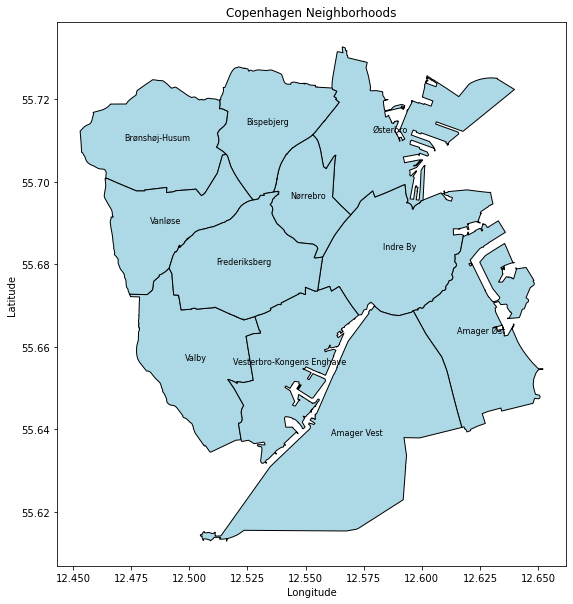

In [141]:
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.plot(ax=ax, color='lightblue', edgecolor='k')


# Annotate each neighborhood with its name
for idx, row in neighborhoods.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=8, ha='center')

ax.set_title("Copenhagen Neighborhoods")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


### Results density

In [142]:
interests_by_neighborhood = gpd.sjoin(neighborhoods, results, how="left", op="contains")

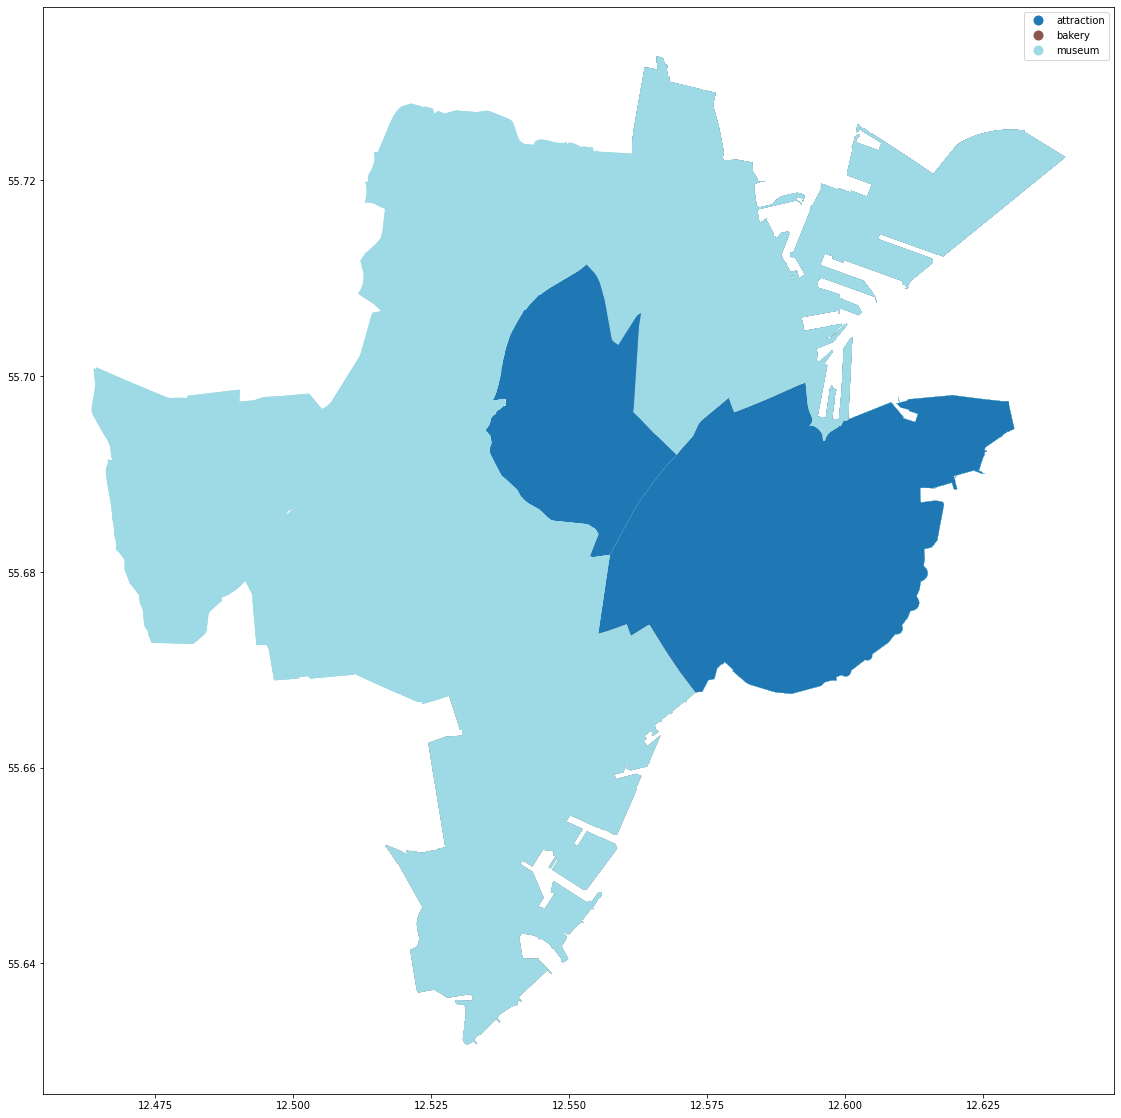

In [143]:
ax = interests_by_neighborhood.plot(
    column="interest", 
    categorical=True, 
    legend=True,
    figsize=(20, 20), 
    cmap='tab20' 
)

plt.show()

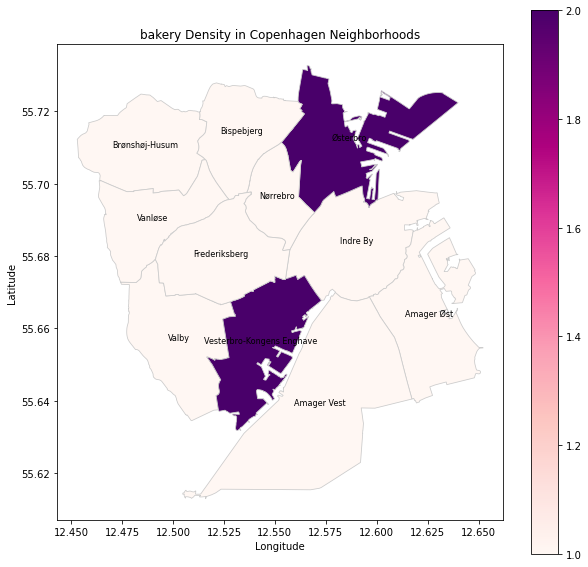

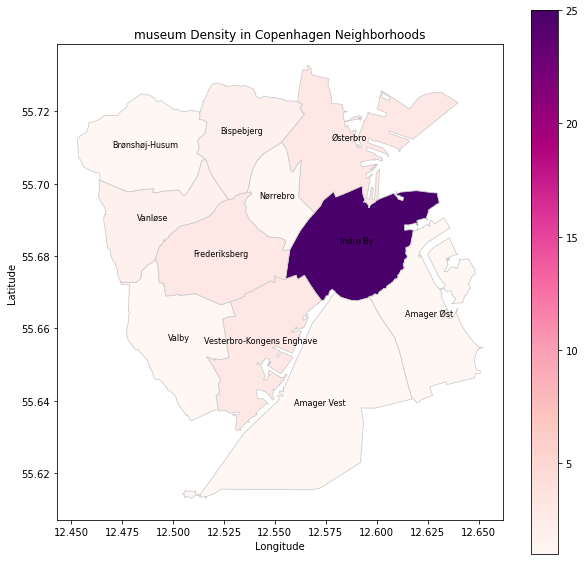

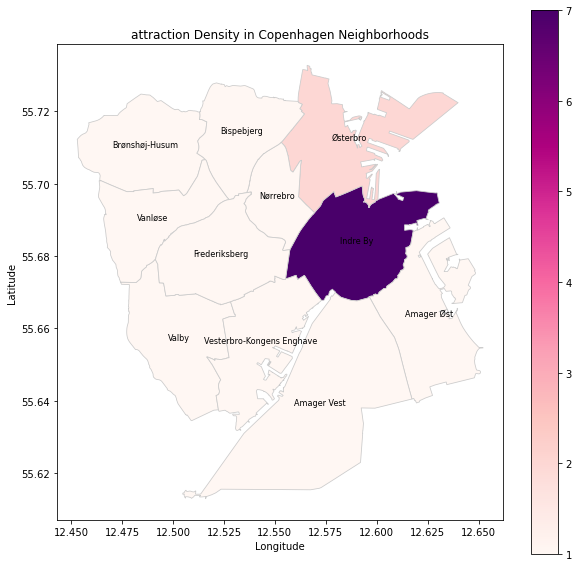

In [144]:
categories = list(results['interest'].unique())

counts_by_category = {}

for category in categories:
    category_gdf = results[results['interest'] == category]
    merged_gdf = gpd.sjoin(neighborhoods, category_gdf, how="left", op="contains")
    counts_by_neighborhood = merged_gdf.groupby('name').size().reset_index(name=f"{category}_count")
    neighborhoods_with_counts = neighborhoods.merge(counts_by_neighborhood, on="name", how="left")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    neighborhoods_with_counts.plot(column=f"{category}_count", cmap="RdPu", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
    for idx, row in neighborhoods.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=8, ha='center')

    ax.set_title(f"{category} Density in Copenhagen Neighborhoods")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

### Neighborhood selection

In [150]:
interests_by_neighborhood2 = gpd.sjoin(results, neighborhoods[['name','geometry']], how="left", op="within")
#interests_by_neighborhood2.head()

In [151]:
copenhagen_neighborhoods = ['Indre By', 'Østerbro', 'Valby', 'Vesterbro-Kongens Enghave',
                            'Amager Øst', 'Brønshøj-Husum', 'Nørrebro', 'Bispebjerg',
                            'Vanløse', 'Amager Vest', 'Frederiksberg', 'None']

neighborhood_radio_buttons = widgets.RadioButtons(options=copenhagen_neighborhoods)

output = widgets.Output()

# Store neighborhood preferences
neighborhood_preferences = {neighborhood: False for neighborhood in copenhagen_neighborhoods}

def update_preferences(change):
    selected_neighborhood = change.new
    
    for neighborhood in neighborhood_preferences:
        if neighborhood == selected_neighborhood:
            neighborhood_preferences[neighborhood] = True
        else:
            neighborhood_preferences[neighborhood] = False

    with output:
        output.clear_output()
        
neighborhood_radio_buttons.observe(update_preferences, 'value')

display(neighborhood_radio_buttons)
display(output)

RadioButtons(options=('Indre By', 'Østerbro', 'Valby', 'Vesterbro-Kongens Enghave', 'Amager Øst', 'Brønshøj-Hu…

Output()

In [152]:
def neigh(pref, df):
    filt = []
    for interest, selected in pref.items():
        if selected:
            if interest=='None':
                filt = 'No preference'
            else:
                filt.append(interest)
            
    if filt == 'No preference':
        return df
    else:
        return df[df['name'].isin(filt)]

In [153]:
results2 = neigh(neighborhood_preferences, interests_by_neighborhood2)
results2.head()

,interest,interest_name,website,phone,opening_hours,wheelchair,cuisine,diet:vegan,diet:vegetarian,geometry,index_right,name
2526,bakery,Emmerys,None,None,"Mo-Fr 07:00-18:00; Sa,Su 07:00-17:00",yes,None,yes,yes,POINT (12.58434 55.70291),1.0,Østerbro
2628,bakery,BUKA Østerbro,https://www.buka-bakery.com/,None,"""summer 08:00-15:00""",None,None,None,yes,POINT (12.57769 55.70039),1.0,Østerbro
2700,attraction,Brumleby,None,None,24/7,yes,None,None,None,POINT (12.57523 55.70109),1.0,Østerbro
2724,museum,Østerbro lille Museum,https://detlillemuseum.dk/,+45 61278864,Fr 11:00-15:00; Sa-Th off; Dec 16-Jan 10 off,no,None,None,None,POINT (12.57843 55.70985),1.0,Østerbro
2729,attraction,Spejlhuset,None,None,None,None,None,None,None,POINT (12.56994 55.69734),1.0,Østerbro


### Itinerary generation

In [154]:
import random
import requests
from shapely.geometry import Point

# Convert the geospatial DataFrame to a list of dictionaries
geospatial_data = results2.to_dict('records')    ### REPLACE THE DATA HERE

n = 8
if len(results2) < 8:
    n = len(results2)

selected_places = random.sample(geospatial_data, random.randint(5,n))

selected_places_df = pd.DataFrame(selected_places)
selected_places_df

,interest,interest_name,website,phone,opening_hours,wheelchair,cuisine,diet:vegan,diet:vegetarian,geometry,index_right,name
0,museum,Østerbro lille Museum,https://detlillemuseum.dk/,+45 61278864,Fr 11:00-15:00; Sa-Th off; Dec 16-Jan 10 off,no,None,None,None,POINT (12.5784297 55.7098542),1.0,Østerbro
1,bakery,Emmerys,None,None,"Mo-Fr 07:00-18:00; Sa,Su 07:00-17:00",yes,None,yes,yes,POINT (12.5843388 55.7029074),1.0,Østerbro
2,museum,Brumleby Museum,http://www.brumlebymuseum.dk/,None,Su 11:00-15:00,no,None,None,None,POINT (12.5756085 55.7019168),1.0,Østerbro
3,museum,Himmel og Hav,http://www.nordhavnen.dk/oplev+nordhavnen/udst...,None,None,None,None,None,None,POINT (12.5979173 55.7081968),1.0,Østerbro
4,bakery,BUKA Østerbro,https://www.buka-bakery.com/,None,"""summer 08:00-15:00""",None,None,None,yes,POINT (12.5776852 55.7003923),1.0,Østerbro
5,attraction,Brumleby,None,None,24/7,yes,None,None,None,POINT (12.5752343 55.7010933),1.0,Østerbro


In [155]:
w_dist5kmB = weights.DistanceBand.from_dataframe(selected_places_df, threshold=5000, binary=False)

In [156]:
neighbors_list_dist = w_dist5kmB.neighbors

In [157]:
def find_closest_neigh(current, w_dist5kmB, itinerary, n):
    neighbors = w_dist5kmB[current]
    sorted_neigh = dict(sorted(neighbors.items(), key=lambda item: item[1], reverse=True))
    
    new = None
    for neigh  in sorted_neigh.keys():
        if neigh not in itinerary:
            itinerary.append(neigh)
            new = neigh
            break
            
    if len(itinerary) == n:
        return itinerary
    else:
        return find_closest_neigh(new, w_dist5kmB, itinerary, n)

itinerary = [0]
ordered_itinerary = find_closest_neigh(0, w_dist5kmB, itinerary, len(selected_places_df))

print(ordered_itinerary)                                      

[0, 2, 5, 4, 1, 3]


In [158]:
selected_places_df = selected_places_df.reindex(ordered_itinerary)
selected_places_df

,interest,interest_name,website,phone,opening_hours,wheelchair,cuisine,diet:vegan,diet:vegetarian,geometry,index_right,name
0,museum,Østerbro lille Museum,https://detlillemuseum.dk/,+45 61278864,Fr 11:00-15:00; Sa-Th off; Dec 16-Jan 10 off,no,None,None,None,POINT (12.5784297 55.7098542),1.0,Østerbro
2,museum,Brumleby Museum,http://www.brumlebymuseum.dk/,None,Su 11:00-15:00,no,None,None,None,POINT (12.5756085 55.7019168),1.0,Østerbro
5,attraction,Brumleby,None,None,24/7,yes,None,None,None,POINT (12.5752343 55.7010933),1.0,Østerbro
4,bakery,BUKA Østerbro,https://www.buka-bakery.com/,None,"""summer 08:00-15:00""",None,None,None,yes,POINT (12.5776852 55.7003923),1.0,Østerbro
1,bakery,Emmerys,None,None,"Mo-Fr 07:00-18:00; Sa,Su 07:00-17:00",yes,None,yes,yes,POINT (12.5843388 55.7029074),1.0,Østerbro
3,museum,Himmel og Hav,http://www.nordhavnen.dk/oplev+nordhavnen/udst...,None,None,None,None,None,None,POINT (12.5979173 55.7081968),1.0,Østerbro


In [159]:
selected_places = selected_places_df.to_dict('records')   
waypoints = ";".join([f"{Point(place['geometry']).x},{Point(place['geometry']).y}" for place in selected_places])

In [160]:
osrm_url = f"http://router.project-osrm.org/route/v1/driving/{waypoints}?overview=false"
response = requests.get(osrm_url)
data = response.json()

itinerary = data.get("routes", [])[0].get("legs", [])

In [161]:
# Display itinerary
print("Itinerary (by walking):")
for i, leg in enumerate(itinerary):
    start_place = selected_places[i]["interest_name"]
    end_place = selected_places[i+1]["interest_name"] if i < len(selected_places) - 1 else selected_places[0]["interest_name"]
    distance = leg["distance"] / 1000  # Convert distance from meters to kilometers
    duration = distance * 12.25  # Convert duration from seconds to minutes
    print(f"{i+1}. Interest {selected_places[i]['interest']}. From {start_place} to {end_place}: Distance - {distance:.2f} km, Duration - {duration:.2f} minutes")

Itinerary (by walking):
1. Interest museum. From Østerbro lille Museum to Brumleby Museum: Distance - 1.14 km, Duration - 13.98 minutes
2. Interest museum. From Brumleby Museum to Brumleby: Distance - 0.29 km, Duration - 3.53 minutes
3. Interest attraction. From Brumleby to BUKA Østerbro: Distance - 0.32 km, Duration - 3.92 minutes
4. Interest bakery. From BUKA Østerbro to Emmerys: Distance - 0.64 km, Duration - 7.89 minutes
5. Interest bakery. From Emmerys to Himmel og Hav: Distance - 1.67 km, Duration - 20.46 minutes


In [162]:
# Get route geometries
osrm_url = f"http://router.project-osrm.org/route/v1/driving/{waypoints}?overview=full&geometries=geojson"
response = requests.get(osrm_url)
data = response.json()

route_geometry = data.get("routes", [])[0].get("geometry", {})

# Create map
map_center = [sum(place['geometry'].y for place in selected_places) / len(selected_places),
              sum(place['geometry'].x for place in selected_places) / len(selected_places)]
mymap = folium.Map(location=map_center, zoom_start=14)

icon_html = """<div style="
                width: 30px;
                height: 30px;
                border-radius: 50%;
                background-color: #337ab7;
                color: white;
                display: flex;
                justify-content: center;
                align-items: center;
                font-size: 14px;
                font-weight: bold;
                border: 2px solid #2e6da4;
                ">
                {number}
               </div>"""
    
marker_cluster = MarkerCluster().add_to(mymap)

# Create numbered markers for selected places 
i=1
for place in selected_places:
    number = i
    icon = folium.DivIcon(html=icon_html.format(number=number))
    marker = folium.Marker([place['geometry'].y, place['geometry'].x], icon=icon, popup=place['interest_name'])
    marker.add_to(marker_cluster)
    i += 1

folium.features.GeoJson(route_geometry).add_to(mymap)

# Display the map
mymap